# Explore COVID-19 for a particular state

by [Irena Fischer-Hwang](https://github.com/irenatfh)

Stanford University's Big Local News project performed basic analysis of Tweets posted by local government agencies in the United States regarding the COVID-19 pandemic.

This notebook pulls in data from a variety of sources including an exported CSV of Tweets, a Google Sheet containing government agency twitter handles, a Google Sheet summarizing shelter-in-place orders for different states and The Covid Tracking project.

Users specify one particular state, and data for that state are summarized and displayed in simple plots comparing quantities like cumulative tweets, cumulative tweets regarding COVID-19, retweets, shelter-in-place orders and basic statistics about confirmed COVID-19 cases.

Nomenclature notes:

    Variable names of pandas dataframes start with df_
    Variable names of pandas series start with series_
    Variable names of pandas indices start with index_

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import tweepy
import us
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from adjustText import adjust_text
from datetime import timedelta

## Set library parameters

In [2]:
# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

# Pandas + matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Pyplot options
plt.rcParams.update({'font.size': 16, 'font.sans-serif': 'Arial'})

## Import data

### Tweets

Replace `tweets_sheet` with the path to your local copy of Twitter data

In [3]:
tweets_sheet = '../data/source/tweets-20200406-1732PST.csv'  # Replace path for local data
df_tweets = pd.read_csv(tweets_sheet, dtype={'user': object})
# df_tweets.head()

/Users/ihwang/.local/share/virtualenvs/covid19-tweets-jKmwAzGh/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### The COVID Tracking Project

Historical state cases data is accessed directly from The COVID Tracking Project (https://covidtracking.com/api/)

In [4]:
df_states_cases = pd.read_json('https://covidtracking.com/api/states/daily')
df_states_cases['dateChecked'] = pd.to_datetime(df_states_cases['dateChecked'])
df_states_cases['date'] = pd.to_datetime(df_states_cases['date'], format='%Y%m%d')
# df_states_cases.head()

### Local government Twitter Handles

Local government Twitter Handles are stored in the [`Official_twitter_handles` Google Sheet](https://docs.google.com/spreadsheets/d/13wRn7ZswD2p180OQY7JiJgv-CHug36CiQqFkhpzQYwY). Note: GUIDs refer to the IDs of individual sheeets within the Google Sheet.

In [5]:
sheet_key = '13wRn7ZswD2p180OQY7JiJgv-CHug36CiQqFkhpzQYwY'
guid_dict = {
    'Healthcare': 64630233,
    'Governers': 470577166,
    'Congress': 354414704
}

Get all local government agency handles

In [6]:
state_dfs_list = []
for guid_key, guid in guid_dict.items():
    handles_sheet = 'https://docs.google.com/spreadsheets/d/' + sheet_key + \
                    '/export?format=csv&gid=%s' %guid
    state_dfs_list.append(pd.read_csv(handles_sheet))
df_hc_handles, df_gov_handles, df_congress_handles = state_dfs_list

### Shelter-in-place orders

Information about shelter-in-place orders are located in the [`shelter-in-place` Google Sheet](https://docs.google.com/spreadsheets/d/1iOChy4gxV3RUz2uHYRHL5OwSbyIV8p9Jo1tTR-R1-Hw). Again, GUIDs refer to the IDs of individual sheeets within the Google Sheet.

In [7]:
sheet_key = '1iOChy4gxV3RUz2uHYRHL5OwSbyIV8p9Jo1tTR-R1-Hw'
guid_dict = {
    'States': 0,
    'Cities': 1430032085,
    'Counties': 1083934346
}

Specify which GUID you'd like to examine

In [8]:
guid = guid_dict['States']  # Replace key with desired agency type

In [9]:
handles_sheet = 'https://docs.google.com/spreadsheets/d/' + sheet_key + '/export?format=csv&gid=%s' %guid
df_sip = pd.read_csv(handles_sheet)
df_sip['Date effective'] = pd.to_datetime(df_sip['Date effective'])
# df_sip.sort_values('State')

### Twitter API

Access Twitter API in order to get Twitter user IDs for user screenames (handles).

To access the API, you'll need to create a Twitter developer account and obtain API credentials. Currently the code assumes that Twitter credentials are stored in a file where `CONSUMER_KEY`, `CONSUMER_SECRET_KEY`, `ACCESS_TOKEN`, `ACCESS_TOKEN_SECRET` are separated from their values with an equals sign `=`, and each listed in a new line.

In [10]:
twitter_creds = '../.env'  # Replace path with for local file

with open(twitter_creds) as f:
    for line in f:
        line_contents = line.strip().split('=')
        if line_contents[0] == 'CONSUMER_KEY':
            consumer_key = line_contents[1]
        elif line_contents[0] == 'CONSUMER_SECRET_KEY':
            consumer_secret = line_contents[1]
        elif line_contents[0] == 'ACCESS_TOKEN':
            access_token = line_contents[1]
        elif line_contents[0] == 'ACCESS_TOKEN_SECRET':
            access_token_secret = line_contents[1]
        else:
            pass

Access Twitter API

In [11]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

## Declare global variables

* Strings related to COVID-19 include: `coronavirus`, `covid` and `ncov`, since some of the most popular hashtags related to the pandemic have been `#ncov2019`, `coronavirus` and `covid` (according to a quick spot-check). The keywords `virus` and `cdc` were too general---some health departments were tweeting about flu and other general health recommendations from the CDC in December 2019.
* CDC and WHO are two large healthcare organizations which may be of interest, so we defined a dictionary of their Twitter handles.

In [12]:
covid_strings = 'coronavirus|covid|ncov'
hc_org_dict = {
    'cdc' : '146569971',
    'who' : '14499829'
}

Specify the state you'd like to focus on

In [13]:
state = 'GA'  # Replace with the state abbreviation of interest

In [14]:
state_name = us.states.lookup(state).name
hc_dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Department'].iloc[0]
hc_handle = df_hc_handles[df_hc_handles['Abbreviation'] == state]['Twitter Handle'].iloc[0]
gov = df_gov_handles[df_gov_handles['Abbreviation'] == state]['Governor'].iloc[0]
gov_handle = df_gov_handles[df_gov_handles['Abbreviation'] == state]['Handle'].iloc[0]
sip_date = df_sip[df_sip['State'] == state_name]['Date effective'].iloc[0]

## Process raw data

Get Twitter user IDs from handles

In [15]:
hc_user_id = str(api.get_user(hc_handle).id)
gov_user_id = str(api.get_user(gov_handle).id)

Create `df_hc_tweets` and `df_gov_tweets` dataframes and do some basic cleaning up on them

In [16]:
# Join df_tweets and df_hc_handles/df_gov_handles to get dataframes Tweets
df_hc_tweets = df_tweets[df_tweets['user'] == hc_user_id].copy()
df_gov_tweets = df_tweets[df_tweets['user'] == gov_user_id].copy()

# Transform created_at column from Timestamp to DateTime object
df_hc_tweets['created_at'] = pd.to_datetime(df_hc_tweets['created_at'])
df_gov_tweets['created_at'] = pd.to_datetime(df_gov_tweets['created_at'])

for subject, df in [(hc_dept, df_hc_tweets), (gov, df_gov_tweets)]:
    print('Tweets by the %s since December 1, 2019: %s' %(subject, len(df)))

Tweets by the Georgia Department of Public Health since December 1, 2019: 140
Tweets by the Brian Kemp since December 1, 2019: 352


Extract tweets from health departments mentioning COVID-19

In [17]:
# Filter for keywords coronavirus and covid (not case-sensitive)
df_hc_covid_tweets = df_hc_tweets[(df_hc_tweets['full_text'].\
                                  str.contains(covid_strings, regex=True, case=False))]
df_gov_covid_tweets = df_gov_tweets[(df_gov_tweets['full_text'].\
                                  str.contains(covid_strings, regex=True, case=False))]

for subject, df in [(hc_dept, df_hc_covid_tweets), (' governor of ' + state_name + ', ' + gov, df_gov_covid_tweets)]:
    print('COVID-19 Tweets by the %s since December 1, 2019: %s' 
          %(subject, len(df)))

COVID-19 Tweets by the Georgia Department of Public Health since December 1, 2019: 92
COVID-19 Tweets by the  governor of Georgia, Brian Kemp since December 1, 2019: 188


Cumulative plots of all Tweets

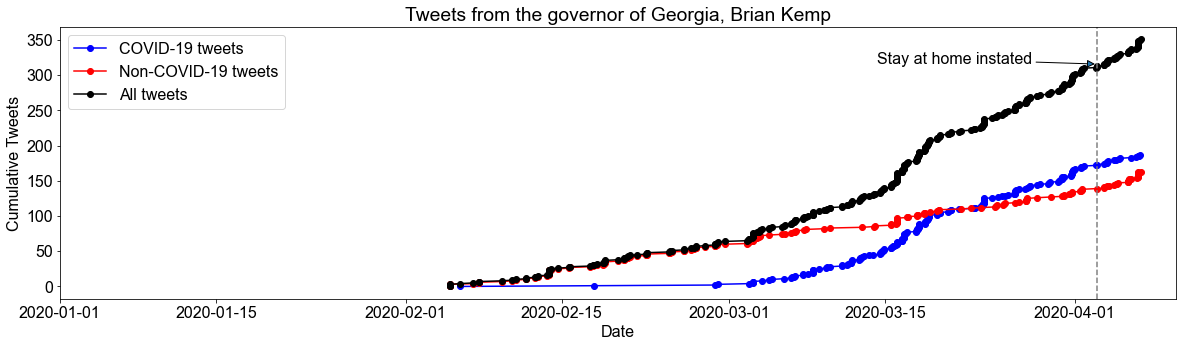

In [18]:
subject = gov  # Uncomment to plot Tweets from the governor
# subject = hc_dept  # Uncomment to plot Tweets from the state healthcare department

if subject == gov:
    subject = 'governor of ' + state_name + ', ' + gov
    df_plot = df_gov_covid_tweets
    df_all = df_gov_tweets
else:
    df_plot = df_hc_covid_tweets
    df_all = df_hc_tweets

# Define df
df_plot = df_plot.sort_values('created_at').reset_index()
df_plot2 = df_all[
    ~(df_all['full_text'].str.contains(covid_strings, regex=True, case=False))
]
df_plot2 = df_plot2.sort_values('created_at').reset_index()
df_plot3 = df_all
df_plot3 = df_plot3.sort_values('created_at').reset_index()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))

axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue', label='COVID-19 tweets')
axes.plot(df_plot2['created_at'], df_plot2.index, 'o-', color='red', label='Non-COVID-19 tweets')
axes.plot(df_plot3['created_at'], df_plot3.index, 'o-', color='black', label='All tweets')

if pd.notnull(sip_date):
    sip_order = df_sip[df_sip['State'] == state_name]['Order'].iloc[0]
    axes.axvline(x=mdates.date2num(sip_date), linestyle='--', color='grey')
    axes.annotate(sip_order + ' instated', (mdates.date2num(sip_date), .9*max(df_plot3.index)), xytext=(-220,0), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_title('Tweets from the %s' %subject)
axes.set_ylabel('Cumulative Tweets')
axes.set_xlabel('Date')
axes.legend(loc='upper left')
plt.show()

Plot governor's and healthcare department's Tweets about COVID-19 with state hospitalization, positive test cases and deaths

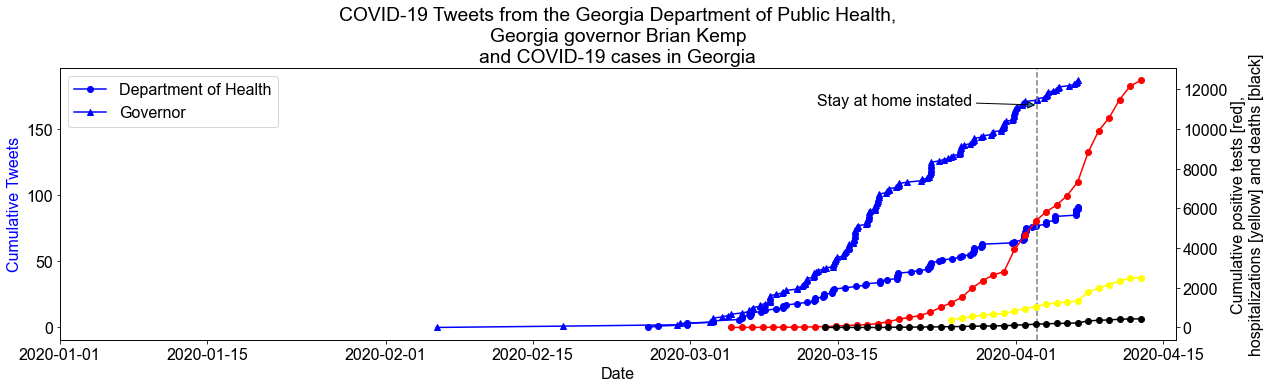

In [19]:
# Define df
df_plot_hc = df_hc_covid_tweets
df_plot_hc = df_plot_hc.sort_values('created_at').reset_index()
df_plot_gov = df_gov_covid_tweets
df_plot_gov = df_plot_gov.sort_values('created_at').reset_index()
df_state = df_states_cases[df_states_cases['state'] == state]

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()

axes.plot(df_plot_hc['created_at'], df_plot_hc.index, 'o-', color='blue', label='Department of Health')
axes.plot(df_plot_gov['created_at'], df_plot_gov.index, '^-', color='blue', label='Governor')
axes2.plot(df_state['dateChecked'], df_state['positive'], 'o-', color='red')
axes2.plot(df_state['dateChecked'], df_state['death'], 'o-', color='black')
axes2.plot(df_state['dateChecked'], df_state['hospitalized'], 'o-', color='yellow')

if pd.notnull(sip_date):
    sip_order = df_sip[df_sip['State'] == state_name]['Order'].iloc[0]
    axes.axvline(x=mdates.date2num(sip_date), linestyle='--', color='grey')
    axes.annotate(sip_order + ' instated', 
                  (mdates.date2num(sip_date), .9*max(max(df_plot_hc.index), max(df_plot_gov.index))), 
                  xytext=(-220,0), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_title('COVID-19 Tweets from the %s,\n%s governor %s\nand COVID-19 cases in %s' 
               %(hc_dept, state_name, gov, us.states.lookup(state).name))
axes.set_ylabel('Cumulative Tweets', color='blue')
axes2.set_ylabel('Cumulative positive tests [red],\nhospitalizations [yellow] and deaths [black]')
axes.set_xlabel('Date')
axes.legend()
plt.show()

Get a feel for engagement with and by the account:
* Engagement by the account: total number of Tweets that are retweets or quotes
* Engagement with the account: total retweets of this acccount's Tweets

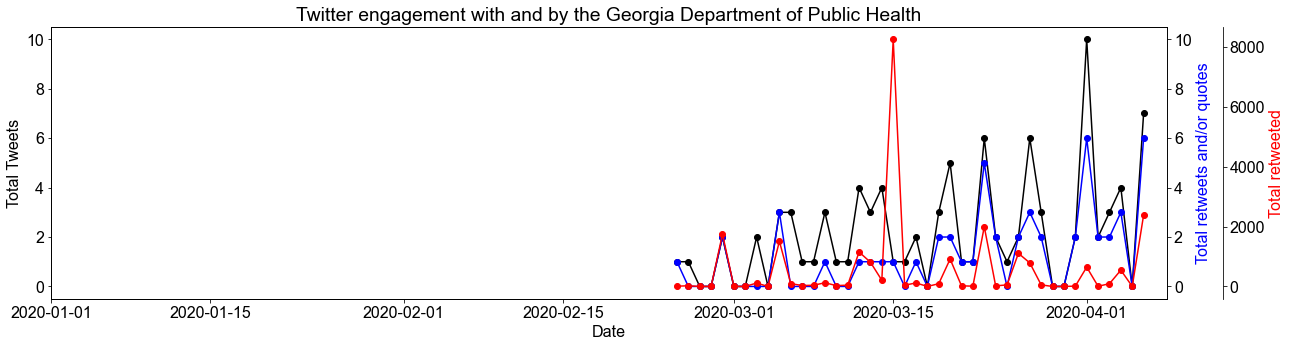

In [20]:
# subject = gov  # Uncomment to plot Tweets from the governor
subject = hc_dept  # Uncomment to plot Tweets from the state healthcare department

if subject == gov:
    subject = 'governor of ' + state_name + ', ' + gov
    df_plot = df_gov_covid_tweets
    df_all = df_gov_tweets
else:
    df_plot = df_hc_covid_tweets
    df_all = df_hc_tweets

# Define df
df_total = df_plot[['created_at']].resample('D', on='created_at').count()
df_engaged_with_counts = df_plot[['created_at', 'retweeted_status', 'quoted_status']].resample('D', on='created_at').count()
series_engaged_with = df_engaged_with_counts.drop(columns=['created_at']).sum(axis=1)
df_engaged_by = df_plot[['created_at', 'retweet_count']].resample('D', on='created_at').sum()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()
axes3 = axes.twinx()
rspine = axes3.spines['right']
rspine.set_position(('axes', 1.05))

axes.plot(df_total.index, df_total, 'o-', color='black')
axes2.plot(series_engaged_with.index, series_engaged_with, 'o-', color='blue')
axes3.plot(df_engaged_by.index, df_engaged_by['retweet_count'], 'o-', color='red')

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes2.set_ylim(axes.get_ylim())
axes.set_title('Twitter engagement with and by the %s' %subject)
axes.set_ylabel('Total Tweets', color='black')
axes2.set_ylabel('Total retweets and/or quotes', color='blue')
axes3.set_ylabel('Total retweeted', color='red')
axes.set_xlabel('Date')
plt.show()

## Review Tweets

Let's look at the Tweets more closely. Uncomment the following cell to display all Tweets about COVID from the state's healthcare agency, sorted chronologically.

In [21]:
# df_hc_covid_tweets.sort_values('created_at')

Uncomment the following cell to display all Tweets about COVID from the state's governor, sorted chronologically.

In [22]:
# df_gov_covid_tweets.sort_values('created_at')